In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

In [3]:
#data location
column_definition_path="./Data/column_definitions.xlsx"
airline_data_path="./Data/DS_airline_delay_causes.csv"

#import data to dataframes
flight_data_df=pd.read_csv(airline_data_path)
column_definition_df=pd.read_excel(column_definition_path)

In [4]:
#displaying first five rows
print("Displaying first five rows of Flight data")
flight_data_df.head()

Displaying first five rows of Flight data


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Unnamed: 21
0,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.00,...,0.00,0.0,0.0,266.0,65.0,0.0,201.0,0.0,0.0,NaN
1,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.00,...,0.00,0.0,0.0,81.0,57.0,0.0,24.0,0.0,0.0,NaN
2,2009,11,AS,Alaska Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",66.0,6.0,1.28,0.69,...,0.00,0.0,0.0,176.0,64.0,11.0,101.0,0.0,0.0,NaN
3,2009,11,AS,Alaska Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",59.0,10.0,0.24,0.00,...,0.56,0.0,0.0,553.0,8.0,0.0,526.0,0.0,19.0,NaN
4,2009,11,AS,Alaska Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",85.0,18.0,1.34,1.46,...,0.00,0.0,0.0,547.0,85.0,89.0,373.0,0.0,0.0,NaN


In [5]:
#getting basic info of the flight data 
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73282 entries, 0 to 73281
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73282 non-null  int64  
 1    month               73282 non-null  int64  
 2   carrier              73282 non-null  object 
 3   carrier_name         73282 non-null  object 
 4   airport              73282 non-null  object 
 5   airport_name         73282 non-null  object 
 6   arr_flights          73240 non-null  float64
 7   arr_del15            73211 non-null  float64
 8   carrier_ct           73240 non-null  float64
 9    weather_ct          73240 non-null  float64
 10  nas_ct               73240 non-null  float64
 11  security_ct          73240 non-null  float64
 12  late_aircraft_ct     73240 non-null  float64
 13  arr_cancelled        73240 non-null  float64
 14  arr_diverted         73240 non-null  float64
 15   arr_delay           73240 non-null 

In [6]:
# Count missing values per column
missing_values = flight_data_df.isnull().sum()

print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
year                       0
 month                     0
carrier                    0
carrier_name               0
airport                    0
airport_name               0
arr_flights               42
arr_del15                 71
carrier_ct                42
 weather_ct               42
nas_ct                    42
security_ct               42
late_aircraft_ct          42
arr_cancelled             42
arr_diverted              42
 arr_delay                42
 carrier_delay            42
weather_delay             42
nas_delay                 42
security_delay            42
late_aircraft_delay       42
Unnamed: 21            73282
dtype: int64


In [7]:
## DATASET CLEANUP ###

#Removing Unnamed: 21 feature
flight_data_df.drop('Unnamed: 21', axis=1, inplace=True)

#Removing Samples with missing values
flight_data_df.dropna(inplace=True)

#we observe space between some features, we remove them
flight_data_df.rename(columns=lambda x: x.lstrip() if x.startswith(' ') else x, inplace=True)

#check for duplicate data samples
duplicates = flight_data_df.duplicated().sum()
#print(f"Number of duplicate rows: {duplicates}\n")

#dropping duplicate rows
flight_data_df.drop_duplicates(inplace=True)

# Replace negative values in nas_ct and nas_delay with 0
flight_data_df["nas_ct"] = flight_data_df["nas_ct"].apply(lambda x: max(x, 0))
flight_data_df["nas_delay"] = flight_data_df["nas_delay"].apply(lambda x: max(x, 0))

# As airport code and airport denote the same value, we drop it. We do similar to carrier and carrier_code
flight_data_df.drop('carrier_name', axis=1, inplace=True)
flight_data_df.drop('airport_name', axis=1, inplace=True)

In [8]:
#getting current df.info
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73211 entries, 0 to 73281
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73211 non-null  int64  
 1   month                73211 non-null  int64  
 2   carrier              73211 non-null  object 
 3   airport              73211 non-null  object 
 4   arr_flights          73211 non-null  float64
 5   arr_del15            73211 non-null  float64
 6   carrier_ct           73211 non-null  float64
 7   weather_ct           73211 non-null  float64
 8   nas_ct               73211 non-null  float64
 9   security_ct          73211 non-null  float64
 10  late_aircraft_ct     73211 non-null  float64
 11  arr_cancelled        73211 non-null  float64
 12  arr_diverted         73211 non-null  float64
 13  arr_delay            73211 non-null  float64
 14  carrier_delay        73211 non-null  float64
 15  weather_delay        73211 non-null  floa

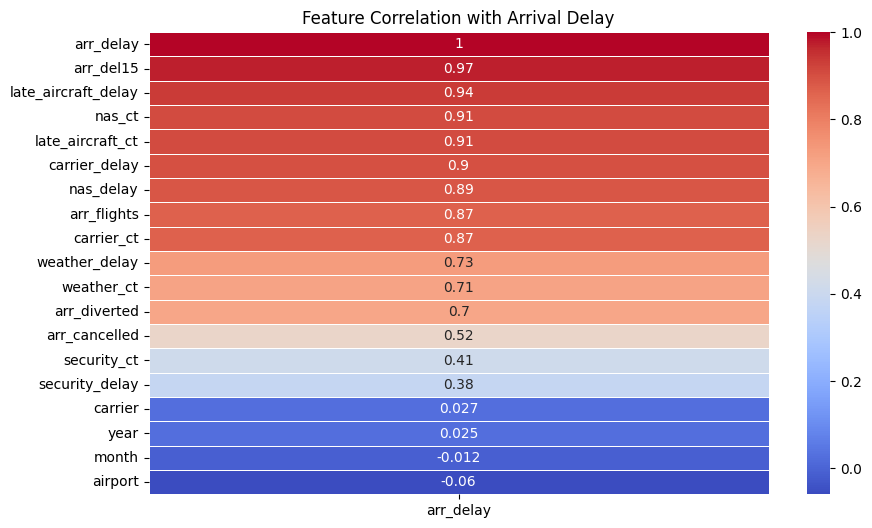

In [9]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['carrier', 'airport']

for col in categorical_cols:
    le = LabelEncoder()
    flight_data_df[col] = le.fit_transform(flight_data_df[col])
    label_encoders[col] = le

# Compute correlation matrix
corr_matrix = flight_data_df.corr()

# Plot heatmap of correlations with `arr_delay`
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['arr_delay']].sort_values(by='arr_delay', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Arrival Delay")
plt.show()

In [10]:
#handling skewness

# Identify numerical columns (excluding categorical ones)
numerical_columns = flight_data_df.select_dtypes(include=["float64"]).columns #removing int64 as it only contains year, month, carrier and airport

# Calculate skewness for each numerical column
skewness = flight_data_df[numerical_columns].skew()

# Apply log transformation for high-skew columns (adding 1 to avoid log(0))
skewed_cols = skewness[skewness > 1].index
for col in skewed_cols:
    flight_data_df[col] = np.log1p(flight_data_df[col])

# Shift `nas_delay` to make all values positive
shift_constant = abs(flight_data_df["nas_delay"].min()) + 1  # Ensures positive values
flight_data_df["nas_delay"] = np.log1p(flight_data_df["nas_delay"] + shift_constant)

# Replace infinite values with NaN and then impute with median
flight_data_df = flight_data_df.replace([np.inf, -np.inf], np.nan).fillna(flight_data_df.median(numeric_only=True))

# Adjust limits as needed
flight_data_df.clip(lower=-1e10, upper=1e10, inplace=True)  

In [11]:
# Define features and target variable
features = ['carrier', 'airport', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 
            'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_delay', 'weather_delay', 
            'nas_delay', 'security_delay', 'late_aircraft_delay']

X = flight_data_df[features]
Y = flight_data_df['arr_delay']

# Define number of folds
num_folds = 5

# Measure execution time
start_time = time.time()

# Define K-Fold cross-validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train a Linear Regreesion
model = LinearRegression()

# Store results
cv_scores = []
predictions = []
actual_values = []
fold_indices = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store results for visualization
    predictions.extend(y_pred)
    actual_values.extend(Y_test)
    fold_indices.extend([fold] * len(Y_test))
    
    # Evaluate the model
    score = model.score(X_test, Y_test)  # R² score
    cv_scores.append(score)

# Convert lists to NumPy arrays for easier plotting
predictions = np.array(predictions)
actual_values = np.array(actual_values)
fold_indices = np.array(fold_indices)
cv_scores = np.array(cv_scores)


# End time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Evaluate the model
# Compute mean and standard deviation of R² scores

mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)

In [12]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Square Error (MSE): {mse}")
print(f"Standard Deviation R2: {std_r2}")
print(f"Mean R2 score: {mean_r2}")
print(f"Execution Time: {execution_time} seconds")
print(f"Cross Validation Scores:{cv_scores}")

Mean Absolute Error (MAE): 0.17513630636915467
Mean Square Error (MSE): 0.08082566446339985
Standard Deviation R2: 0.00043993684620569046
Mean R2 score: 0.9770135424809325
Execution Time: 0.3201112747192383 seconds
Cross Validation Scores:[0.97676857 0.97777182 0.97644962 0.97695687 0.97712083]


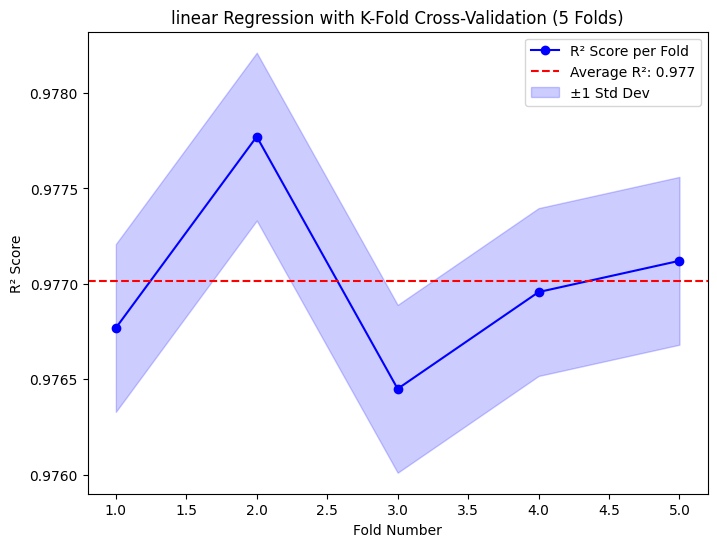

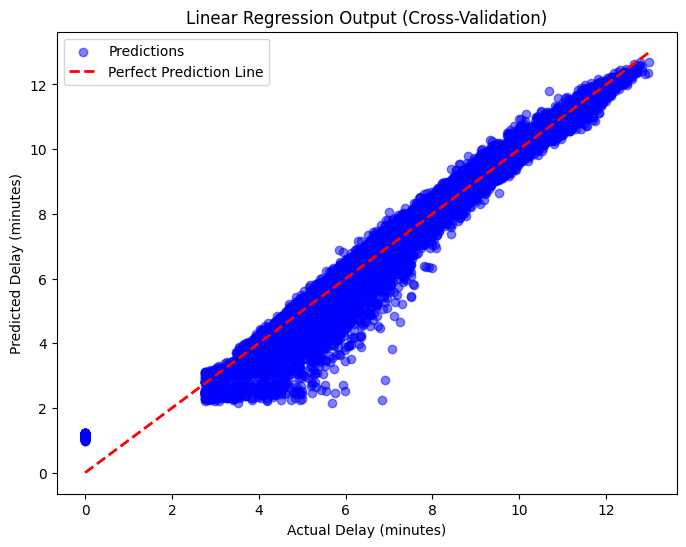

/tmp/ipykernel_279531/1775672498.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[fold_indices == i] for i in range(1, kf.get_n_splits() + 1)],


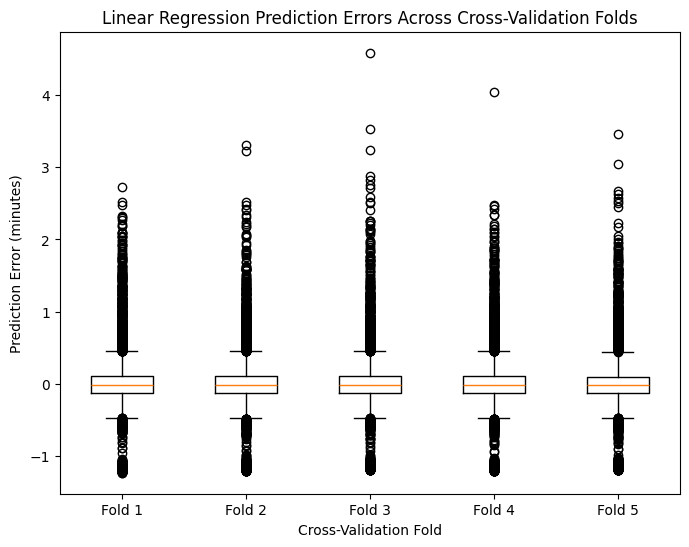

In [13]:
# Visualization: R² Scores per Fold
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='blue', label='R² Score per Fold')
plt.axhline(mean_r2, color='red', linestyle='dashed', label=f'Average R²: {mean_r2:.3f}')
plt.fill_between(range(1, len(cv_scores) + 1), cv_scores - std_r2, cv_scores + std_r2, color='blue', alpha=0.2, label='±1 Std Dev')
plt.xlabel("Fold Number")
plt.ylabel("R² Score")
plt.title("linear Regression with K-Fold Cross-Validation (5 Folds)")
plt.legend()
plt.show()

# Visualization: Actual vs. Predicted Delays (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions, alpha=0.5, label="Predictions", color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 
         color='red', linestyle='dashed', linewidth=2, label="Perfect Prediction Line")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Linear Regression Output (Cross-Validation)")
plt.legend()
plt.show()

# Visualization: Prediction Error Boxplot Across Folds
errors = actual_values - predictions

plt.figure(figsize=(8, 6))
plt.boxplot([errors[fold_indices == i] for i in range(1, kf.get_n_splits() + 1)], 
            labels=[f"Fold {i}" for i in range(1, kf.get_n_splits() + 1)])
plt.xlabel("Cross-Validation Fold")
plt.ylabel("Prediction Error (minutes)")
plt.title("Linear Regression Prediction Errors Across Cross-Validation Folds")
plt.show()
